# Assess spectral norm variability

The computation of the spectral norm is now slower than computing the lensing operator and the noise levels in starlet space. In order to obtain further gain in computation time, we would like to assess the dependency of the spectral norm of the operator H(F(Phi_T_s().)) to variations of F, i.e. to variations of lens model parameters.

If it does not vary a lot, we do not have to recompute the spectral norm at each lens model proposition. It can be approximated to a conservative estimate, or recompute every $N$ iterations.

In [1]:
__author__ = 'aymgal'
import copy
import pprint
import tqdm
import numpy as np
import matplotlib.pyplot as plt

import lenstronomy.Util.util as lenstro_util
from lenstronomy.Data.imaging_data import ImageData
from lenstronomy.Data.psf import PSF
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.Util import kernel_util

from lenstronomy.ImSim.image_sparse_solve import ImageSparseFit
from slitronomy.Util.util import dirac_impulse
from slitronomy.Util.plot_util import nice_colorbar

%matplotlib inline

lens_model_type = 'power-law'
perfect_seeing = False

np.random.seed(42)

In [2]:
lin_scale = lambda x: x
log_scale = lambda x: np.log10(x)
sqrt_scale = lambda x: np.sqrt(x)

## Setup sparse solver

In [3]:
# data specifics
num_pix = 99  # cutout pixel size
delta_pix = 0.08  # pixel size in arcsec (area per pixel = deltaPix**2)

background_rms = 0.05  # background noise per pixel

psf_fwhm = 0.2  # full width half max of PSF, in delta_pix units
psf_num_pix = 41

In [4]:
# data specification (coordinates, etc.)
_, _, ra_at_xy_0, dec_at_xy_0, _, _, Mpix2coord, _ \
    = lenstro_util.make_grid_with_coordtransform(numPix=num_pix, deltapix=delta_pix, subgrid_res=1, 
                                                 inverse=False, left_lower=False)

kwargs_data = {
    'background_rms': background_rms,
    'noise_map': background_rms * np.ones((num_pix, num_pix)),
    'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0, 
    'transform_pix2angle': Mpix2coord,
    'image_data': np.zeros((num_pix, num_pix)) # we do not care about the actual imaging data
}
data_class = ImageData(**kwargs_data)

In [5]:
# PSF specification
if perfect_seeing:
    kwargs_psf = {'psf_type': 'NONE'}
else:
    psf_kernel = kernel_util.kernel_gaussian(psf_num_pix, delta_pix, psf_fwhm)
    print(psf_kernel.shape)
    kwargs_psf = {'psf_type': 'PIXEL', 'kernel_point_source': psf_kernel}
    #kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': psf_fwhm, 'pixel_size': delta_pix, 'truncation': 11}
psf_class = PSF(**kwargs_psf)

#plt.title("PSF kernel")
#im = plt.imshow(psf_class.kernel_point_source, origin='lower')
#nice_colorbar(im)
#plt.show()

(41, 41)


In [6]:
if lens_model_type == 'power-law':
    lens_model_list = ['SPEMD', 'SHEAR_GAMMA_PSI']
    kwargs_spemd = {'theta_E': 1.8, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}
    kwargs_shear = {'gamma_ext': 0.02, 'psi_ext': 0, 'ra_0': 0, 'dec_0': 0}
    kwargs_lens = [kwargs_spemd, kwargs_shear]
elif lens_model_type == 'composite':
    lens_model_list = ['HERNQUIST', 'NFW_ELLIPSE', 'SHEAR_GAMMA_PSI']
    kwargs_hernquist = {'theta_E': 1.8, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}
    kwargs_nfw = {'Rs': 20, 'gamma': 2, 'center_x': 0, 'center_y': 0, 'e1': 0, 'e2': 0}
    kwargs_shear = {'gamma_ext': 0.02, 'psi_ext': 0, 'ra_0': 0, 'dec_0': 0}
    kwargs_lens = [kwargs_spemd, kwargs_shear]
lens_model_class = LensModel(lens_model_list=lens_model_list)

source_model_list = ['STARLETS']
kwargs_source = [{'n_scales': 6}]
source_model_class = LightModel(light_model_list=source_model_list)

kwargs_sparse_solver = {
    'source_interpolation': 'bilinear',
    'subgrid_res_source': 2,
    'minimal_source_plane': False,
    'fixed_spectral_norm_source': None,  # otherwise it fixes a value...which is not what we want here ;) 
}

imageSparseFit = ImageSparseFit(data_class, psf_class=psf_class, 
                                lens_model_class=lens_model_class,
                                source_model_class=source_model_class,
                                kwargs_sparse_solver=kwargs_sparse_solver)
sparseSolver = imageSparseFit.sparseSolver
sparseSolver.prepare_solver(kwargs_lens, kwargs_source)
print("initial source operator spectral norm", sparseSolver.spectral_norm_source)

initial source operator spectral norm 0.9811394749665199


## Draw samples of lens model parameters and compute spectral norm

In [7]:
n_iter = 2000
n_scales_list = [6, 10]

spec_norm_list = []
kwargs_lens_list = []
for n_scales_iter in n_scales_list:
    kwargs_source_iter = copy.deepcopy(kwargs_source)
    kwargs_source_iter[0]['n_scales'] = n_scales_iter
    spec_norm_sublist = []
    kwargs_lens_sublist = []
    for _ in tqdm.tqdm(range(n_iter)):
        kwargs_lens_iter = copy.deepcopy(kwargs_lens)
        if lens_model_type == 'power-law':
            kwargs_lens_iter[0]['theta_E'] = np.random.uniform(0.5, delta_pix*num_pix/4)
            kwargs_lens_iter[0]['gamma'] = np.random.uniform(1.8, 2.2)
            kwargs_lens_iter[0]['center_x'] = np.random.uniform(-0.5, 0.5)
            kwargs_lens_iter[0]['center_y'] = np.random.uniform(-0.5, 0.5)
            kwargs_lens_iter[0]['e1'] = np.random.uniform(-0.5, 0.5)
            kwargs_lens_iter[0]['e2'] = np.random.uniform(-0.5, 0.5)
        kwargs_lens_iter[-1]['gamma_ext'] = np.random.uniform(0, 0.02)
        kwargs_lens_iter[-1]['psi_ext'] = np.random.uniform(-np.pi, np.pi)
        kwargs_lens_sublist.append(kwargs_lens_iter)
        try:
            # compute lensing operator and spectral norm
            sparseSolver.prepare_solver(kwargs_lens_iter, kwargs_source_iter)
        except:
            spec_norm_sublist.append(np.nan)  # most likely an error in lensing op
        else:
            spec_norm_sublist.append(sparseSolver.spectral_norm_source)
    kwargs_lens_list.append(kwargs_lens_sublist)
    spec_norm_list.append(spec_norm_sublist)
spec_norm_list = np.array(spec_norm_list).T

100%|██████████| 2000/2000 [10:22<00:00,  3.18it/s]


/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.
/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  
/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future

[10.52442303 10.00765295] [0.95635298 0.95806724] [192.5085083  168.11957627] 0.023443470967510722


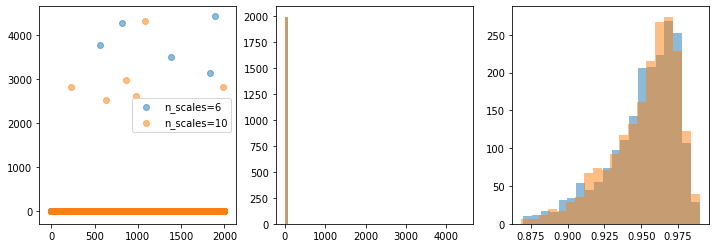

In [10]:
print(np.nanmean(spec_norm_list, axis=0), 
      np.nanmedian(spec_norm_list, axis=0), 
      np.nanstd(spec_norm_list, axis=0),
      np.nanstd(spec_norm_list[spec_norm_list <= 1], axis=0))

fig = plt.figure(figsize=(12, 4))
for i in range(len(n_scales_list)):
    ax = plt.subplot(1, 3, 1)
    ax.scatter(range(n_iter), spec_norm_list[:, i], alpha=0.5, label="n_scales={}".format(n_scales_list[i]))
    ax.legend()
    ax = plt.subplot(1, 3, 2)
    ax.hist(spec_norm_list[:, i], bins=50, alpha=0.5)
    ax = plt.subplot(1, 3, 3)
    ax.hist(spec_norm_list[spec_norm_list[:, i] <= 1, i], bins=20, alpha=0.5)
plt.show()

In [28]:
indices_large_norm = np.where(spec_norm_list[:, 0] > 1)[0]
print(indices_large_norm)
for idx in indices_large_norm:
    print(spec_norm_list[idx, 0])
    pprint.pprint(kwargs_lens_list[0][idx])
    

[ 561  813 1384 1831 1885]
3780.7470822262185
[{'center_x': 0.07503777500059206,
  'center_y': -0.31820041759343365,
  'e1': -0.4283950231868061,
  'e2': 0.057446758389545605,
  'gamma': 2.1728237989917485,
  'theta_E': 1.6219473048213209},
 {'dec_0': 0,
  'gamma_ext': 2.3450389256935987e-05,
  'psi_ext': 0.4788519266916702,
  'ra_0': 0}]
4267.6756259892645
[{'center_x': 0.16618523177178168,
  'center_y': -0.1535930031693078,
  'e1': -0.11857199318853673,
  'e2': -0.44243719962818917,
  'gamma': 2.1958726402120368,
  'theta_E': 1.9220067071592635},
 {'dec_0': 0,
  'gamma_ext': 0.005813361456995696,
  'psi_ext': 2.3536768384917632,
  'ra_0': 0}]
3498.970738508474
[{'center_x': -0.36011502888184777,
  'center_y': 0.17072110948575991,
  'e1': -0.14123215893847818,
  'e2': -0.25862022458169154,
  'gamma': 2.194052791014312,
  'theta_E': 1.8301267469466134},
 {'dec_0': 0,
  'gamma_ext': 0.009356289626257727,
  'psi_ext': -0.5229017915274188,
  'ra_0': 0}]
3141.9084646349497
[{'center_x': 0.

/Users/aymericg/anaconda3/envs/pystro36/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


In [27]:
indices_nans_norm = np.where(np.isnan(spec_norm_list[:, 0]))[0]
print(indices_nans_norm)
for idx in indices_nans_norm:
    print(spec_norm_list[idx, 0])
    pprint.pprint(kwargs_lens_list[0][idx])

[ 338 1461 1625 1773]
nan
[{'center_x': 0.08340375752421136,
  'center_y': 0.34246147724569653,
  'e1': 0.12996490669726768,
  'e2': -0.34325053149240325,
  'gamma': 2.1624478445386965,
  'theta_E': 1.8976428679014956},
 {'dec_0': 0,
  'gamma_ext': 0.00315502941319737,
  'psi_ext': -0.7818627981718933,
  'ra_0': 0}]
nan
[{'center_x': -0.3138928203797744,
  'center_y': 0.088828287604928,
  'e1': 0.37420309403827035,
  'e2': -0.25590789061949837,
  'gamma': 2.1644626400207443,
  'theta_E': 1.8734921317759825},
 {'dec_0': 0,
  'gamma_ext': 0.01342381325421365,
  'psi_ext': 2.741580665843891,
  'ra_0': 0}]
nan
[{'center_x': -0.334508350440185,
  'center_y': 0.4459645245951164,
  'e1': 0.2834985624807044,
  'e2': 0.2532519477569165,
  'gamma': 2.1693115520179154,
  'theta_E': 1.9586193991733443},
 {'dec_0': 0,
  'gamma_ext': 0.00493975414787069,
  'psi_ext': 0.3706958756196128,
  'ra_0': 0}]
nan
[{'center_x': 0.2429275011447216,
  'center_y': -0.49292691365747265,
  'e1': 0.2357534103661238